# Multilingual emoji prediction project

Import tools

In [ ]:
import os
import pandas as pd
import sklearn
import json
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from glob import glob
from datetime import datetime
from keras.engine.saving import load_model, model_from_json
from numpy import argmax
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


## Load the proprocessed data 

In [2]:
NAME_OF_MODEL_FOR_NN = "Models/model5.h5"
os.makedirs(os.path.dirname("Models/"), exist_ok=True)

PreprocessedDataFolder = "PreprocessedData"
trainFile = PreprocessedDataFolder+"/train.prepro"
testFile = PreprocessedDataFolder+"/test.prepro"
HistoryFolder = "History"


preprocessed_data = []
with open(trainFile, 'r', encoding="utf_8") as f:
    preprocessed_data = [s.rstrip() for s in f.readlines()]

pd.DataFrame(preprocessed_data[:3])

0
0       may fight 'm still happi big part life
1  hey fun boot camp n't forget tshirt us navi
2                      make heart happi times…

In [3]:
%%time
preprocessed_data_test = []
with open(testFile, 'r', encoding="utf_8") as f:
    preprocessed_data_test = [s.rstrip() for s in f.readlines()]

pd.DataFrame(preprocessed_data_test[:3])

Wall time: 23 ms


0
0                  idk wat got rite ni adventur land
1            dream come true disney 's magic kingdom
2  let festiv begin planet hollywood resort amp c...

In [4]:
len(preprocessed_data)

205421

In [5]:
len(preprocessed_data_test)

51356

In [6]:
trainFile = PreprocessedDataFolder+"/train.emojis"
testFile = PreprocessedDataFolder+"/test.emojis"
y_train_full = []
with open(trainFile, 'r', encoding="utf_8") as f:
    y_train_full = [int(s.rstrip()) for s in f.readlines()]

In [7]:
y_test = []
with open(testFile, 'r', encoding="utf_8") as f:
    y_test = [int(s.rstrip()) for s in f.readlines()]

# Representation

#### building BOW and TF IDF

In [8]:
%%time
vect = CountVectorizer(min_df=2)
train_dtm = vect.fit_transform(preprocessed_data)

Wall time: 1.67 s


In [9]:
train_dtm.shape

(205421, 30731)

In [10]:
%%time
tfidf_transformer = TfidfTransformer()
train_dtm = tfidf_transformer.fit_transform(train_dtm)


Wall time: 81 ms


In [11]:
train_dtm.shape

(205421, 30731)

In [12]:
test_dtm = vect.transform(preprocessed_data_test)
test_dtm = tfidf_transformer.transform(test_dtm)



# Classification

define tools functions to help evaluate simple classifiers

In [13]:
#cell inspired from https://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost/index.html
outputFile = "Log/log.txt"
os.makedirs(os.path.dirname(outputFile), exist_ok=True)

import datetime
def log(x):
    #can be used to write to log file
    print(x)
    out_data = open(outputFile, 'a', encoding="utf_8")
    out_data.write(x)
    out_data.close()
    
from time import time
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix
def test_classifier(X_train, y_train, X_test, y_test, classifier,classLabels,evalName=""):
    logstr = ""
    logstr += "===============================================\n"
    logstr += str(datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y"))+"\n"
    classifier_name = str(type(classifier).__name__)
    logstr += "Testing " + classifier_name+"\n"
    now = time()
    #list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    logstr += "Learing time {0}s".format(time() - now)+"\n"
    now = time()
    predictions = model.predict(X_test)
    logstr += "Predicting time {0}s".format(time() - now)+"\n"
    log(logstr)
    return evaluateClassif(predictions,y_test,classLabels,evalName)
def evaluateClassif(predictions,y_test,classLabels,evalName):
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=classLabels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=classLabels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=classLabels)
    logstr="\n"
    logstr += "=================== Results ==================="+"\n"
    logstr += evalName+"\n"
    logstr += "         "+"    ".join(str(c)+(3-len(str(c)))*" " for c in classLabels)+"\n"
    logstr += "F1       " + "   ".join(["%.2f" % f for f in f1])+"\n"+"\n"
    logstr += "Precision" + "   ".join(["%.2f" % f  for f in precision])+"\n"
    logstr += "Recall   " + "   ".join(["%.2f" % f  for f in recall] )+"\n"
    logstr += "Confusion Matrix : \n"
    confus = confusion_matrix(predictions,y_test)
    for l in confus:
        logstr+=" ".join([str(f)+(5-len(str(f)))*" " for f in l])+"\n"
    logstr += "Accuracy " + str(accuracy)+"\n"
    #logstr += "F1 mean : " + str(f1_score(y_test, predictions, average="micro"))+"\n"
    logstr += "==============================================="+"\n"
    logstr += "==============================================="+"\n"
    log(logstr)
    return precision, recall, accuracy, f1

In [14]:
labels = [str(i) for i in range(20)]

In [15]:
#predict only heart
#Due to the (very) non uniform distribution, especially for heart,
#we obtain a accuracy score of 21% by predicting only heart
prediction = [0 for i in range(len(y_test))]
scores = evaluateClassif(prediction,y_test,labels,"only Heart")

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



=================== Results ===================
only Heart
         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.58   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Precision0.41   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Recall   1.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Confusion Matrix : 
21016 10240 10132 5171  4797 
0     0     0     0     0    
0     0     0     0     0    
0     0     0     0     0    
0     0     0     0     0    
Accuracy 0.4092219020172911



#### Naives bayes

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [17]:
%%time
precision, recall, accuracy, f1 = test_classifier(train_dtm, y_train_full, test_dtm, y_test, BernoulliNB(),labels)

10:51AM on October 28, 2019
Testing BernoulliNB
Learing time 0.10300707817077637s
Predicting time 0.010994911193847656s


=================== Results ===================

         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.65   0.39   0.60   0.16   0.54   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Precision0.55   0.49   0.63   0.45   0.67   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Recall   0.81   0.33   0.58   0.10   0.46   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Confusion Matrix : 
16924 5480  3164  3723  1515 
1867  3376  717   552   371  
1443  1005  5867  314   667  
384   118   55    495   46   
398   261   329   87    2198 
Accuracy 0.5619596541786743

Wall time: 496 ms


d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [18]:
%%time
precision, recall, accuracy, f1 = test_classifier(train_dtm, y_train_full, test_dtm, y_test, MultinomialNB(),labels)

10:52AM on October 28, 2019
Testing MultinomialNB
Learing time 0.0899958610534668s
Predicting time 0.007002592086791992s


=================== Results ===================

         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.64   0.26   0.56   0.03   0.41   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Precision0.49   0.56   0.68   0.58   0.82   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Recall   0.93   0.17   0.47   0.02   0.27   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Confusion Matrix : 
19503 7758  4951  4678  2608 
618   1741  295   215   223  
787   655   4772  177   667  
29    12    9     83    10   
79    74    105   18    1289 
Accuracy 0.5332969857465535

Wall time: 494 ms


d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Logistic regression

In [19]:
%%time
from sklearn.linear_model import LogisticRegression
precision, recall, accuracy, f1 = test_classifier(train_dtm, y_train_full, test_dtm, y_test, LogisticRegression(),labels)

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


10:52AM on October 28, 2019
Testing LogisticRegression
Learing time 13.338998794555664s
Predicting time 0.00500178337097168s


=================== Results ===================

         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.66   0.37   0.61   0.05   0.55   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Precision0.54   0.51   0.63   0.43   0.70   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Recall   0.84   0.29   0.58   0.03   0.46   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Confusion Matrix : 
17614 5941  3324  4174  1602 
1541  2953  556   455   298  
1425  1057  5925  324   674  
105   47    22    147   19   
331   242   305   71    2204 
Accuracy 0.5616286315133577

Wall time: 13.7 s


#### Neural networks

Add other features

In [20]:
from scipy.sparse import hstack, csr_matrix

class FeatureAdder: 
    def __init__(self,train : bool):
        if train : 
            self.file = PreprocessedDataFolder+"/train.addFeatures"
        else : 
            self.file = PreprocessedDataFolder+"/test.addFeatures"

    #data : in out
    def addAllFeatures(self, features : csr_matrix):
        tmp = csr_matrix( pd.read_csv(self.file).iloc[:,1:].values)
        return hstack((features,tmp))

In [21]:
%%time
oldNb = train_dtm.shape[1]
featAdder = FeatureAdder(True)
train_dtm = featAdder.addAllFeatures(train_dtm)
train_dtm.shape[1]-oldNb 

Wall time: 204 ms


7

In [22]:
%%time
featAdder = FeatureAdder(False)
test_dtm = featAdder.addAllFeatures(test_dtm)

Wall time: 57 ms


Creation of our validation set from the training set

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(train_dtm, y_train_full, test_size=0.15, random_state=52)

Binarize our output to do categorical neural network (become a vector, with a 1 in the column of the corresponding output(index)).   

In [24]:
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)
y_valid_binary = to_categorical(y_valid)
y_train_binary[:5]


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [25]:
#helped from https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/
from keras.models import Sequential
from keras.layers import Dense,Dropout,TimeDistributed
from keras.callbacks import EarlyStopping


model = Sequential()

In [26]:
train_dtm.shape

(205421, 30738)

In [27]:
model.add(Dense(2900, input_dim=train_dtm.shape[1], activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(len(y_train_binary[0]), activation='sigmoid'))

In [215]:
#if already a model learned
if os.path.isfile(NAME_OF_MODEL_FOR_NN):
    model = load_model(NAME_OF_MODEL_FOR_NN)

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [29]:
EPOCHS = 30


Define the callback list :
* Early stopping to stop when the loss of the validation set do not improve during 50 epochs
* a ModelCheckpoint, to save the best model

In [30]:
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
filepath = NAME_OF_MODEL_FOR_NN
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')#will save if the val_loss is lower
callbacks_list = [es,checkpoint]

In [31]:
%%time
H = model.fit(X_train, y_train_binary,batch_size=400, epochs=EPOCHS, validation_data=(X_valid, y_valid_binary),callbacks=callbacks_list,use_multiprocessing=True, workers=7,verbose = 2)

Train on 174607 samples, validate on 30814 samples
Epoch 1/30
 - 70s - loss: 1.4248 - accuracy: 0.4121 - val_loss: 1.4375 - val_accuracy: 0.4877

Epoch 00001: val_loss improved from inf to 1.43750, saving model to Models/model5.h5
Epoch 2/30
 - 67s - loss: 1.2820 - accuracy: 0.4841 - val_loss: 1.2805 - val_accuracy: 0.5063

Epoch 00002: val_loss improved from 1.43750 to 1.28052, saving model to Models/model5.h5
Epoch 3/30
 - 66s - loss: 1.2061 - accuracy: 0.5246 - val_loss: 1.1982 - val_accuracy: 0.5260

Epoch 00003: val_loss improved from 1.28052 to 1.19818, saving model to Models/model5.h5
Epoch 4/30
 - 66s - loss: 1.1616 - accuracy: 0.5416 - val_loss: 1.1537 - val_accuracy: 0.5348

Epoch 00004: val_loss improved from 1.19818 to 1.15371, saving model to Models/model5.h5
Epoch 5/30
 - 66s - loss: 1.1313 - accuracy: 0.5531 - val_loss: 1.2053 - val_accuracy: 0.5001

Epoch 00005: val_loss did not improve from 1.15371
Epoch 6/30
 - 66s - loss: 1.1075 - accuracy: 0.5634 - val_loss: 1.1990 

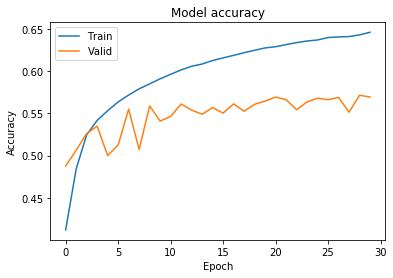

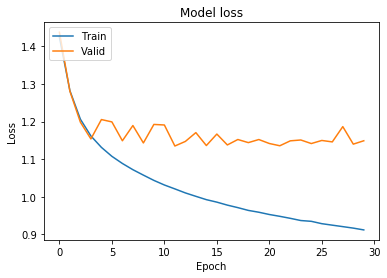

In [33]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

save model history

In [34]:
import pickle

In [35]:
file = HistoryFolder + "/trainHistoryDict"+NAME_OF_MODEL_FOR_NN+".hist"
os.makedirs(os.path.dirname(file), exist_ok=True)

with open(file, 'wb') as file_pi:
    pickle.dump(H.history, file_pi)
    

Evaluate our best model

In [36]:
model = load_model(NAME_OF_MODEL_FOR_NN)

In [37]:
res = model.predict(test_dtm.todense())#warning, use a lot of memory (+10/12Go)

In [38]:
predict = [argmax(r) for r in res]#put in a single number (it was binarize, one hot encoding)

In [39]:
scores = evaluateClassif(predict,y_test,labels,"NN5")

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



=================== Results ===================
NN5
         0      1      2      3      4      5      6      7      8      9      10     11     12     13     14     15     16     17     18     19 
F1       0.65   0.32   0.62   0.07   0.54   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

Precision0.54   0.52   0.57   0.41   0.73   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Recall   0.82   0.24   0.66   0.04   0.43   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
Confusion Matrix : 
17206 6035  2755  4109  1517 
1274  2423  394   357   237  
2111  1492  6710  446   919  
151   71    36    205   38   
274   219   237   54    2086 
Accuracy 0.5574811122361555



#### SVM, uncomment to test gridsearch (warning ; this is very long)

In [40]:
# X_train_small, _, y_train_small, _ = train_test_split(train_dtm, y_train_full, test_size=0.7, random_state=88)

In [41]:
# %%time
from sklearn import svm
# from sklearn.model_selection import GridSearchCV
# parameters = {'C':[0.1,2,9,15],'gamma':[0.001, 0.1, 1, 3]}
# svc = svm.SVC(kernel="rbf")
# clf = GridSearchCV(svc, parameters, cv=3,verbose=2,n_jobs=6)#cv for cross validation
# clf.fit(X_train_small, y_train_small)#take only 1/3 of full data to estime first parameters

In [42]:
# clf.best_params_

In [43]:
# file = "BestParams/SVM20.params"
# os.makedirs(os.path.dirname(file), exist_ok=True)
# 
# with open(file, 'w') as file_pi:
#     file_pi.write(str(clf.best_params_))

In [44]:
# sorted(clf.cv_results_.keys())

In [45]:
#Function from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
# plot_grid_search(clf.cv_results_, [0.001, 0.1, 1, 3], [0.1,2,9,15], 'Gamma', 'C')

In [46]:
# prdictionsSvm = clf.predict(test_dtm)

In [47]:
# scores = evaluateClassif(prdictionsSvm,y_test,labels,"SMV20 tuned, not on all data")

In [48]:
from sklearn.externals import joblib

d:\workspace2\m2sif\sml\emoji\venv\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [49]:
# file = "Models/SVM20Partial.model"
# os.makedirs(os.path.dirname(file), exist_ok=True)
# joblib.dump(clf,file)

learn on all the data with tuned params

In [ ]:
%%time
svc = svm.SVC(kernel="rbf",C=9,gamma = 0.1)
svc.fit(train_dtm,y_train_full)#take full train data

In [ ]:
file = "Models/SVM5.model"
os.makedirs(os.path.dirname(file), exist_ok=True)
joblib.dump(svc,file)

In [ ]:
prdictionsSvm = svc.predict(test_dtm)
scores = evaluateClassif(prdictionsSvm,y_test, labels,"SVM5")

